#  imports

In [1]:
from sklearn.model_selection import train_test_split 
import numpy as np 
import random 
from sklearn.tree import export_graphviz
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pydotplus
from IPython.display import Image

#  loading the data

In [2]:

data_set= pd.read_csv("data.csv")
data_set['result'] = data_set['result'].replace({0: -1})
data_set_size =data_set.shape  
print(data_set_size )

(863, 15)


# Data Preprocessing 

## 1. Encoding the gender (so not bais to specific gender)
## 2. Do StandardScaler to data 


In [3]:
df_with_one_hot = pd.get_dummies(data_set, columns=['gender'], prefix='gender')
df_with_one_hot.head(5)

,Unnamed: 0,location,country,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result,gender_0,gender_1,gender_2
0,0,104,8,66.0,1,0,14,31,19,12,3,1,8,1,0,1,0
1,1,101,8,56.0,0,1,14,31,19,12,3,1,0,-1,1,0,0
2,2,137,8,46.0,0,1,14,31,19,12,3,1,13,-1,0,1,0
3,3,116,8,60.0,1,0,14,31,19,12,3,1,0,-1,1,0,0
4,4,116,8,58.0,0,0,14,31,19,12,3,1,0,-1,0,1,0


In [4]:
scaler = StandardScaler()
numerical_cols = [ 'location', 'country', 'age','symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6','diff_sym_hos']
df_with_one_hot[numerical_cols] = scaler.fit_transform(df_with_one_hot[numerical_cols])
data_set_standardized = pd.DataFrame(df_with_one_hot, columns=df_with_one_hot.columns)
data_set_standardized.head(5)


,Unnamed: 0,location,country,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result,gender_0,gender_1,gender_2
0,0,0.698221,-1.15245,1.101492,1,0,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,2.971339,1,0,1,0
1,1,0.621646,-1.15245,0.437943,0,1,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,-0.422230,-1,1,0,0
2,2,1.540540,-1.15245,-0.225607,0,1,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,5.092319,-1,0,1,0
3,3,1.004519,-1.15245,0.703363,1,0,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,-0.422230,-1,1,0,0
4,4,1.004519,-1.15245,0.570653,0,0,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,-0.422230,-1,0,1,0


In [5]:
labels = df_with_one_hot['result']

# Drop the target column from the features
features = df_with_one_hot.drop('result', axis=1)

In [6]:
#imbalanced data 
labels.value_counts()

-1    755
 1    108
Name: result, dtype: int64

#  divide the data: training, and testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
train_data_sets_size=y_train.shape[0]
print(len(X_test))

173


In [8]:
#show the count of values in training set 
#note : data is imbalanced 
y_train.value_counts()

-1    607
 1     83
Name: result, dtype: int64

# In our approch we consider that :
### - the most importance to us to minimize FN so highest recall is perfered as death (1) or recovered (0) : we see the some important to not to say recovered when the truth is that he/she will die so we cure about to minimizing false negatives so highest recall is preferred
###  -using GridSearch to fine tuning the other parameters ,we use n_repeat =5 to deal with imbalance data

# Decision Trees

## using Recall to get the best hyperparameters for the model


In [9]:
param_grid = {
    'max_depth':range(3, 10, 1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [ 4,5,6,7],
    'criterion': ['gini', 'entropy']
}

dtree = DecisionTreeClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, 
                           cv=cv, n_jobs=-1, verbose=2, scoring='recall')
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
dtree_best_recall_params = grid_result.best_params_


Fitting 25 folds for each of 168 candidates, totalling 4200 fits
Best: 0.790735 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}


## Calculate the accuracy for the recall model

In [10]:
# Use the best hyperparameters found during grid search
dtree_best_recall_ml = DecisionTreeClassifier(max_depth=dtree_best_recall_params['max_depth'],
                                      min_samples_split=dtree_best_recall_params['min_samples_split'],
                                      min_samples_leaf=dtree_best_recall_params['min_samples_leaf'],
                                               criterion=dtree_best_recall_params['criterion'])

# Perform cross-validation for mean accuracy
cv_accuracy = cross_val_score(dtree_best_recall_ml, X_train, y_train, cv=cv, scoring='accuracy')

# Print mean accuracy and standard deviation
print("Mean Accuracy: %f" % cv_accuracy.mean())

Mean Accuracy: 0.953623


# Using accuracy to get the best hyperparameters

## as best recall model is same hyperparameters as best accurate model 

In [11]:
param_grid = {
    'max_depth':range(3, 10, 1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [ 4,5,6,7],
    'criterion': ['gini', 'entropy']
}

dtree = DecisionTreeClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, 
                           cv=cv, n_jobs=-1, verbose=2, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
dtree_best_acc_params = grid_result.best_params_

Fitting 25 folds for each of 168 candidates, totalling 4200 fits
Best: 0.953043 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}


## After finding the best hyperparameters , saving the tree to visualize it 


In [12]:
# Use the best hyperparameters found during grid search
dtree_best_recall_ml = DecisionTreeClassifier(max_depth=dtree_best_recall_params['max_depth'],
                                      min_samples_split=dtree_best_recall_params['min_samples_split'],
                                      min_samples_leaf=dtree_best_recall_params['min_samples_leaf'],
                                               criterion=dtree_best_recall_params['criterion'])
dtree_best_recall_ml.fit(X_train, y_train)
export_graphviz(dtree_best_recall_ml, out_file="tree.dot", 
                feature_names=X_train.columns,  
                class_names=str(dtree_best_recall_ml.classes_),  
                filled=True, rounded=True,  
                special_characters=True)


## draw the decision tree 

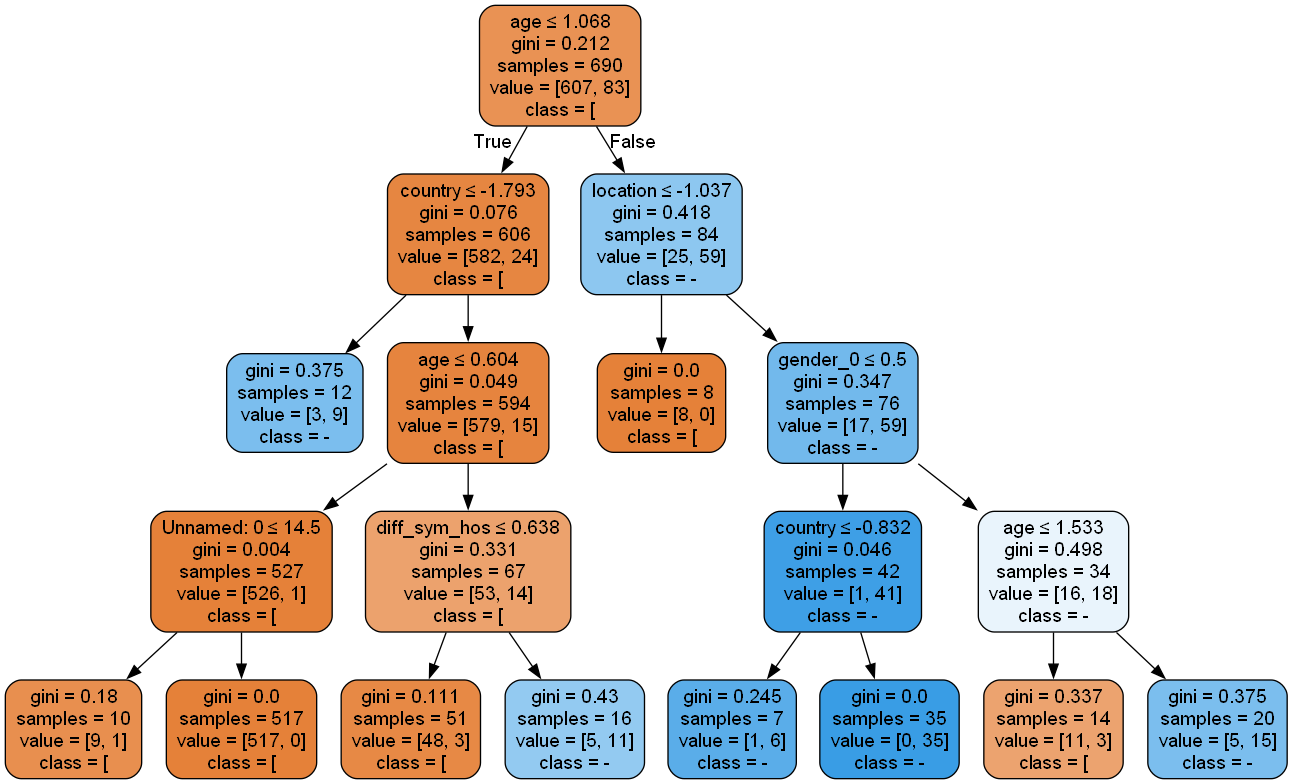

In [13]:

# Load the DOT data
dot_data = open("tree.dot").read()

# Create a graph from DOT data
graph = pydotplus.graph_from_dot_data(dot_data)

# Generate the image
image = Image(graph.create_png())

# Display the image in Jupyter Notebook (or similar environments)
display(image)

# 2. SVM

## first fine tunning the hyperparameters of svm recall model

In [14]:
SVM_model = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],  # for poly kernel only
    'C': [100, 10, 1.0, 0.1, 0.01]
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

grid_search = GridSearchCV(estimator=SVM_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='recall', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

svm_best_recall_params = grid_result.best_params_
print("Best: %f using %s" % (grid_result.best_score_, svm_best_recall_params))


Best: 0.778088 using {'C': 1.0, 'degree': 3, 'kernel': 'linear'}


## Get the hyperparameters of accuracy model 
###  the best model with accuracy is the same the best model of recall

In [15]:
SVM_model = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],  # for poly kernel only
    'C': [100,10, 1.0, 0.1]
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=SVM_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)
svm_best_acc_params = grid_result.best_params_

print("Best: %f using %s" % (grid_result.best_score_, svm_best_acc_params))

Best: 0.956812 using {'C': 1.0, 'degree': 3, 'kernel': 'linear'}


# The Best Model defintion for each DT and SVM

In [16]:
Models = {
    "DT": DecisionTreeClassifier(max_depth=dtree_best_recall_params['max_depth'],
                                 min_samples_split=dtree_best_recall_params['min_samples_split'],
                                 min_samples_leaf=dtree_best_recall_params['min_samples_leaf'],
                                 criterion=dtree_best_recall_params['criterion']),
    "SVM": SVC(kernel=svm_best_recall_params['kernel'],
               C=svm_best_recall_params['C'],
               degree=svm_best_recall_params['degree'],
               probability=True)  # Enable probability estimates
}


# Now after fine tunning the models we will use test set to compare the different models
### 1- Decision Tree has good overall accuracy and has best recall for class -1 (dead people).
### 2- SVM performs good overall accuracy and has best recall for class 1 .
### Both Decision tree and SVM are compareble in performance 
### As we care about the recall of the class -1 more , so the decision tree will be perfered in this case



In [17]:
prediction = {}
for model_name, model in Models.items():
    fitted_model= model.fit(X_train, y_train)
    prediction[model_name]= fitted_model.predict(X_test)
    print(f"{model_name}: {round(model.score(X_test, y_test) * 100, 2)}%")
    print(classification_report(prediction[model_name],y_test))

DT: 93.64%
              precision    recall  f1-score   support

          -1       0.95      0.97      0.96       145
           1       0.84      0.75      0.79        28

    accuracy                           0.94       173
   macro avg       0.90      0.86      0.88       173
weighted avg       0.93      0.94      0.93       173

SVM: 94.22%
              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       150
           1       0.76      0.83      0.79        23

    accuracy                           0.94       173
   macro avg       0.87      0.89      0.88       173
weighted avg       0.94      0.94      0.94       173



### as we can see 4 FN in case of Decision Tree , 6 FN in case of SVM 

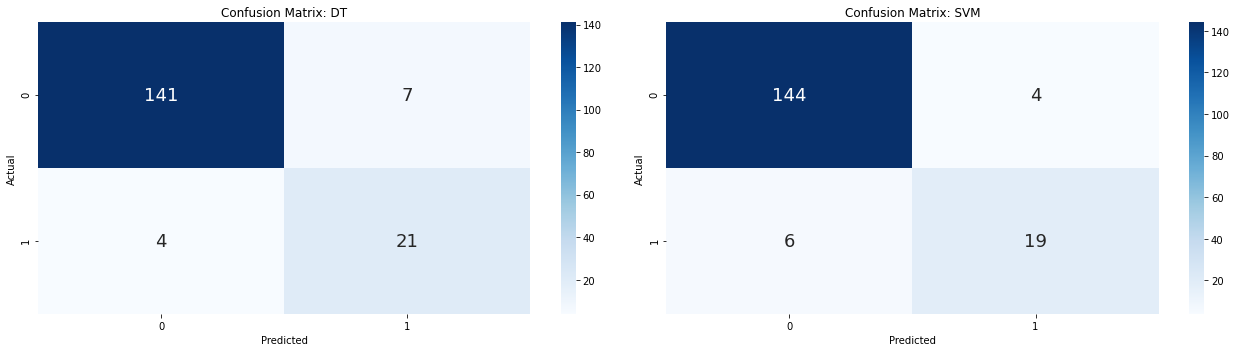

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) 

# Iterate over each (model_name, predicted_labels) pair and its corresponding subplot
for (model_name, predicted_labels), ax in zip(prediction.items(), axes):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    
    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt="d", cmap="Blues", ax=ax)
    
    # Set title and labels
    ax.set(title=f"Confusion Matrix: {model_name}", xlabel="Predicted", ylabel="Actual")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Cross-Validation Score: The SVM model has a slightly higher cross-validation score (0.957971) compared to the DT model (0.944928 )..

### Standard Deviation: The standard deviations of the cross-validation scores are relatively low for both models, with the SVM model having a  lower standard deviation (0.017691) compared to the DT model ( 0.022264). 

In [19]:
Model_df= pd.DataFrame(columns= ["Model", "Cross-val Score", "Standard Deviation"])
Cv = KFold(n_splits=10, shuffle=True, random_state=42)
for model_name, model in Models.items():
    Scores= cross_validate(model, X_train, y_train, cv= Cv, scoring="accuracy")["test_score"]
    Avg_acc= np.mean(Scores)
    Std_acc= np.std(Scores)
    
    Model_df= Model_df.append({"Model": model_name, "Cross-val Score": Avg_acc, "Standard Deviation": Std_acc}, ignore_index= True)

print(Model_df)

  Model  Cross-val Score  Standard Deviation
0    DT         0.944928            0.022264
1   SVM         0.957971            0.017691


## The best model is Decision Tree as it has the largest area under the curve  

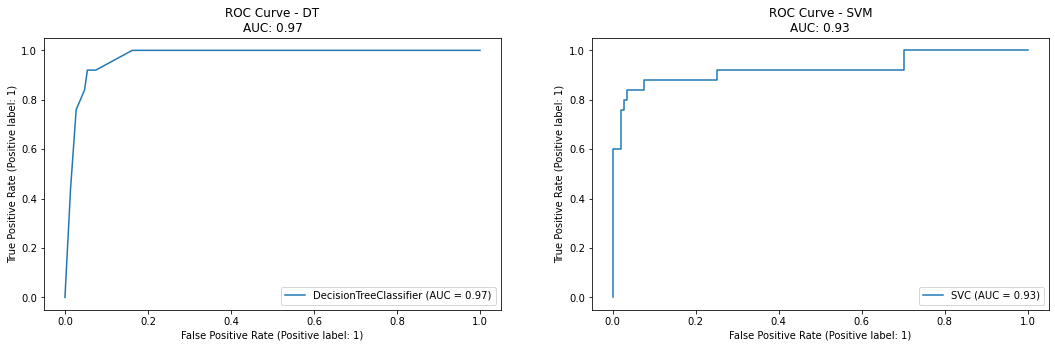

In [20]:

# Create a single figure for all models in the same row
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Iterate over each model and its corresponding axis
for (model_name, model), ax in zip(Models.items(), axes):
    # Fit the model
    fitted_model = model.fit(X_train, y_train)

    # Plot the ROC curve
    plot_roc_curve(fitted_model, X_test, y_test, ax=ax)

    # Calculate the AUC score
    y_pred_proba = fitted_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Set the title with the AUC score
    ax.set_title(f"ROC Curve - {model_name}\nAUC: {auc_score:.2f}")

# Show the plots
plt.show()
